# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
# IMPORT POTREBNIH BIBLIOTEKA
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Reshape

In [2]:
if tf.test.gpu_device_name():
    print('GPU je prepoznat:', tf.test.gpu_device_name())
else:
    print('GPU nije prepoznat.')

GPU je prepoznat: /device:GPU:0


In [3]:
#1. Definiranje putanje do glavnog direktorija
base_dir = r'C:\Users\Pc\Ana projekt\dataset'
train_dir = os.path.join(base_dir,'training')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Class names
class_names = ["Kocka", "Kugla", "Piramida", "Stozac", "Valjak"]

In [4]:
# ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=60,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.15,
    zoom_range=0.20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=256,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 750 images belonging to 5 classes.


Training set:


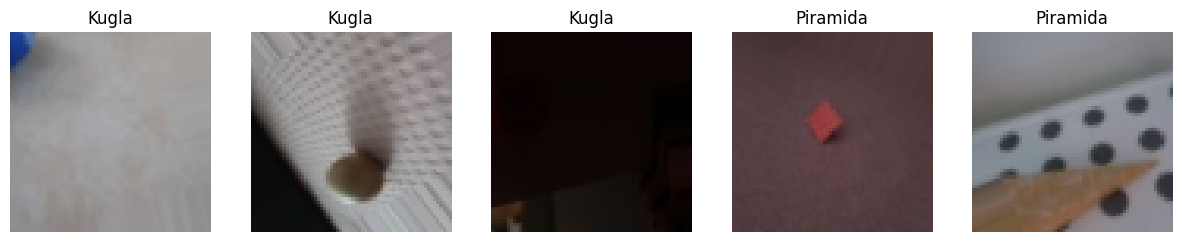

Validation set:


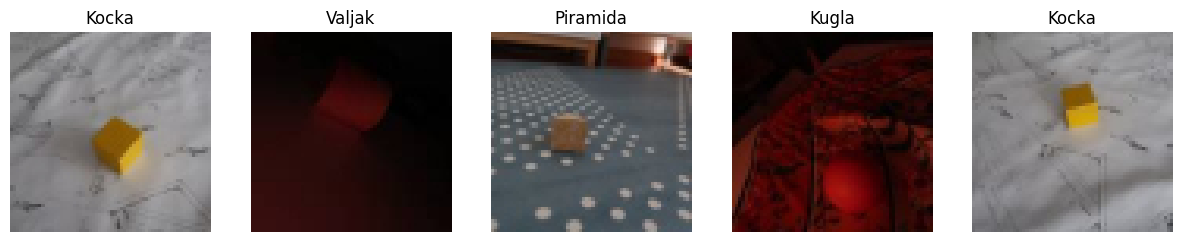

In [5]:
# Function to display images
def show_images(generator, class_names, num_images=5):
    images, labels = next(generator)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].set_title(class_names[np.argmax(labels[i])])
        axes[i].axis('off')
    plt.show()


# Display a few images from the training set
print("Training set:")
show_images(train_generator, class_names, num_images=5)

# Display a few images from the validation set
print("Validation set:")
show_images(val_generator, class_names, num_images=5)

# Display a few images from the test set
# print("Test set:")
# show_images(test_generator, class_names, num_images=5)

# GRAFOVI
def plot_model_accuracy(history):
  loss_train = history.history['accuracy']
  loss_val = history.history['val_accuracy']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def plot_model_loss(history):
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1, len(loss_train)+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model without the fully connected layers and with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze all layers in the base model to prevent their weights from being updated during training
for layer in base_model.layers:
    layer.trainable = True

# Define the model
model1 = Sequential()

# Add the base model (VGG16 without the top layers)
model1.add(base_model)

# Flatten the output from VGG16 to prepare for new conv layers (optional step if adding conv layers)
model1.add(Flatten())

# Add additional convolutional layers (ensure the input shape matches if necessary)
model1.add(Dense(32, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(128, activation='relu'))

# Fully connected layer (as you had originally)
model1.add(Dense(128, activation='relu'))

# Dropout layer to reduce overfitting
model1.add(Dropout(0.5))

# Output layer with 5 neurons for 5 classes and softmax activation
model1.add(Dense(5, activation='softmax'))

# Compile the model with the Adam optimizer
optimizer = Adam(learning_rate=0.0003)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0

In [7]:
history = model1.fit(train_generator, validation_data=val_generator, epochs=300, verbose=2)

# Save the model
model1.save('Ana-model9-vgg16-2.h5')

Epoch 1/300
8/8 - 13s - loss: 1.6184 - accuracy: 0.1890 - val_loss: 1.6075 - val_accuracy: 0.2000 - 13s/epoch - 2s/step
Epoch 2/300
8/8 - 2s - loss: 1.6108 - accuracy: 0.2000 - val_loss: 1.6088 - val_accuracy: 0.2200 - 2s/epoch - 294ms/step
Epoch 3/300
8/8 - 2s - loss: 1.6088 - accuracy: 0.2015 - val_loss: 1.6070 - val_accuracy: 0.2000 - 2s/epoch - 292ms/step
Epoch 4/300
8/8 - 2s - loss: 1.6067 - accuracy: 0.2060 - val_loss: 1.5941 - val_accuracy: 0.2000 - 2s/epoch - 278ms/step
Epoch 5/300
8/8 - 3s - loss: 1.5956 - accuracy: 0.2245 - val_loss: 1.5706 - val_accuracy: 0.2860 - 3s/epoch - 338ms/step
Epoch 6/300
8/8 - 2s - loss: 1.5765 - accuracy: 0.2585 - val_loss: 1.5441 - val_accuracy: 0.3060 - 2s/epoch - 285ms/step
Epoch 7/300
8/8 - 2s - loss: 1.5554 - accuracy: 0.2870 - val_loss: 1.4703 - val_accuracy: 0.3540 - 2s/epoch - 296ms/step
Epoch 8/300
8/8 - 2s - loss: 1.5447 - accuracy: 0.2980 - val_loss: 1.5288 - val_accuracy: 0.3440 - 2s/epoch - 309ms/step
Epoch 9/300
8/8 - 2s - loss: 1.50

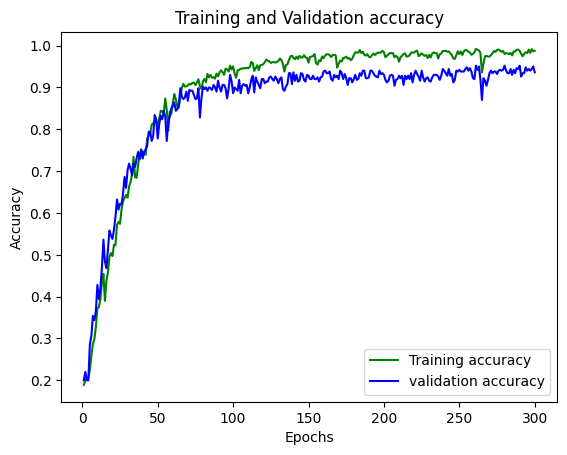

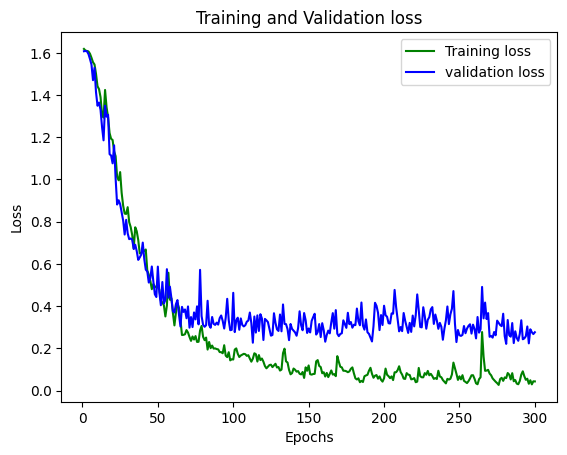

In [8]:
plot_model_accuracy(history)
plot_model_loss(history)

In [9]:
from tensorflow.keras.models import load_model

# Load the model using the local file path
model_path = 'Ana-model9-vgg16-2.h5'  
best_model = load_model(model_path)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

24/24 [==============================] - 1s 27ms/step - loss: 4.0279 - accuracy: 0.5267
Test Loss: 4.0279
Test Accuracy: 52.67%
